In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from numpy.random import default_rng
from scipy import linalg as la
from scipy.special import softmax
from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from lib_fast_solve import * 

# import the heart disease dataset
dataset = "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names =  ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','class']
dataset = pd.read_csv(dataset, names=column_names)

# remove missing data with "?"
df = dataset[~dataset.isin(['?'])]
# drop rows with NaN values from DataFrame
df = df.dropna(axis=0)

# look at the data
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


In [42]:
# checking data type of the dataframe
print (df.dtypes)
# transform data to numeric because the columns ca and thal are object datatypes
data = df.apply(pd.to_numeric)

# create X and Y datasets for training
X = np.array(data.iloc[:,0:13])
y = np.array(data.iloc[:,-1])

# convert to three class classification
y[y==3] = 2
y[y==4] = 2
# plt.hist(y)

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
class         int64
dtype: object


In [43]:
clf = LogisticRegression(penalty='none', fit_intercept=False, multi_class="multinomial")

n, p = np.shape(X)
K = len(np.unique(y)) - 1

# useful deterministic matrices: P Q R 
M = np.eye(K+1) - np.ones((K+1, K+1))/(K+1)
Q = la.cholesky(M, lower=True)[:,:K]
assert np.allclose(Q @ Q.T, M)
assert np.allclose(Q.T @ Q, np.eye(K))

P = np.vstack((np.eye(K), -np.ones((1, K))))
R = np.vstack((np.eye(K), np.zeros((1, K))))

In [44]:
def compute_P_values(X, y, j):

    scaler = StandardScaler()
    X = scaler.fit_transform(X) # standardize covariates

    n, p = np.shape(X)
    K = len(np.unique(y)) - 1

    # estimate omega[j,j]
    X_j = np.delete(X, j, axis=1)
    a = (np.eye(n) - X_j @ la.inv(X_j.T @ X_j) @ X_j.T) @ X[:,j]
    wj = (n - p + 1) / la.norm(a)**2

    Y = np.eye(K+1)[y]
    clf.fit(X, y)
    B_bar = clf.coef_.T # shape (p, K)
    A_hat = B_bar @ P # shape (p, K)

    # old test statistics 
    prob = clf.predict_proba(X) # shape (n, K+1)
    E_Hbar = np.mean(
            prob[:, :, np.newaxis] * np.eye(K+1)[np.newaxis, :, :]
            - prob[:,:, np.newaxis] * prob[:, np.newaxis, :], axis=0)
    cov_old = wj * la.inv(R.T @ E_Hbar @ R) 
    chi2_old = n * A_hat[j,:] @ la.inv(cov_old) @ A_hat.T[:,j]
    
    # new test statistics
    prob_hat = clf.predict_proba(X) # shape (n, K+1)
    G_bar = prob_hat - Y # shape (n, K+1)
    
    if (p*(K+1) <= n+p):
        V_bar = compute_V_solve(X=X, pi=prob_hat, checks=False)
    else:
        V_bar = compute_V_Woodberry(X=X, pi=prob_hat, checks=False)
    
    chi2_new = (wj)**(-1) * A_hat[j,:] @ R.T @ V_bar @ la.pinvh(G_bar.T @ G_bar) @ V_bar @ R @ A_hat.T[:,j]

    p_values = 1 - chi2.cdf([chi2_old, chi2_new], df=K, loc=0, scale=1)
    return p_values

In [48]:
from numpy.random import default_rng

rep = 10000
p_values = np.zeros((rep, 2))
for i in range(rep):
    rng = default_rng(i) 
    X_fake = np.concatenate((X, rng.normal(size = (n, 1))), axis=1)
    p_values[i] = compute_P_values(X_fake, y, p)

flag = (p_values <= 0.05) + 0
np.mean(flag, axis=0)

array([0.0734, 0.0508])

In [46]:
# array([0.0734, 0.0508]) # rep = 10000
# array([0.07419, 0.04968]) # rep = 100000


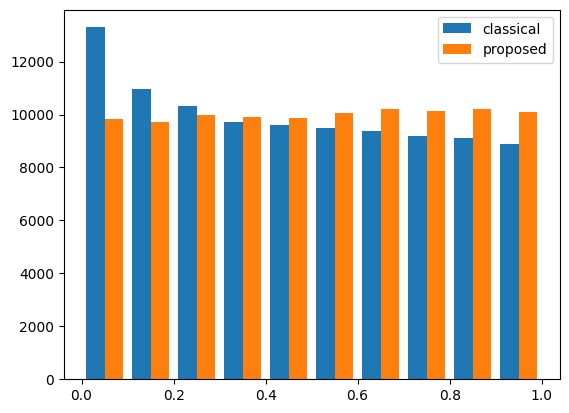

In [47]:
# plt.hist(p_values, label= ["low", 'ss'])
colors = ['classical', 'proposed']
plt.hist(p_values, bins=10, label=colors)
plt.legend(prop={'size': 10})